# Inference on the trained checkpoint

In this notebook we will visualize the results of the training and compute some metrics of importance from a scientific analysis standpoint to further evaluate the performance of the model. This notebook can be executed after the training for the model is complete. 

#### Note

To execute the codes from this notebook, in addition to the PhysicsNeMo docker container, a few other dependencies will be required. They can be installed as follows

```bash
pip install tensorflow
apt-get update
apt install -y libgl1-mesa-glx xvfb
```

Let's jump right in. We will start with making some required imports and loading the hydra configuration

In [1]:
import sys
sys.path.append("../")

from inference import MGNRollout
import hydra
from hydra.utils import to_absolute_path
from hydra import compose, initialize
from physicsnemo.launch.logging import PythonLogger
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

pv.start_xvfb()

initialize(version_base="1.3", config_path="conf")
cfg = compose(config_name="config")

/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-08-29 01:20:39.265970: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 01:20:40.336528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-29 01:20:42.411031: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libr

## Generate model inference

Instantiate the inferencer object that contains all the utilities required to do the basic model prediction for this problem such as the dataloader, normalization / de-normalization of the data, model inference step and a few other helper functions to assist with the plotting and i/o needs. 

In [2]:
logger = PythonLogger("main")  # General python logger
logger.file_logging()

cfg["num_test_samples"] = 1
rollout = MGNRollout(cfg, logger)
idx = [rollout.var_identifier[k] for k in cfg.viz_vars]
rollout.predict()

Preparing the test dataset...


`DistributedManager` not initialized already. Initializing now, but this might lead to unexpected errors
/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/physicsnemo/distributed/manager.py:346: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(
Could not find valid checkpoint file, skipping load


## Create simple animation

Since the current model outputs a transient response for various fields like `u`, `v` and `p`, we can create an animation of the time-series output.

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


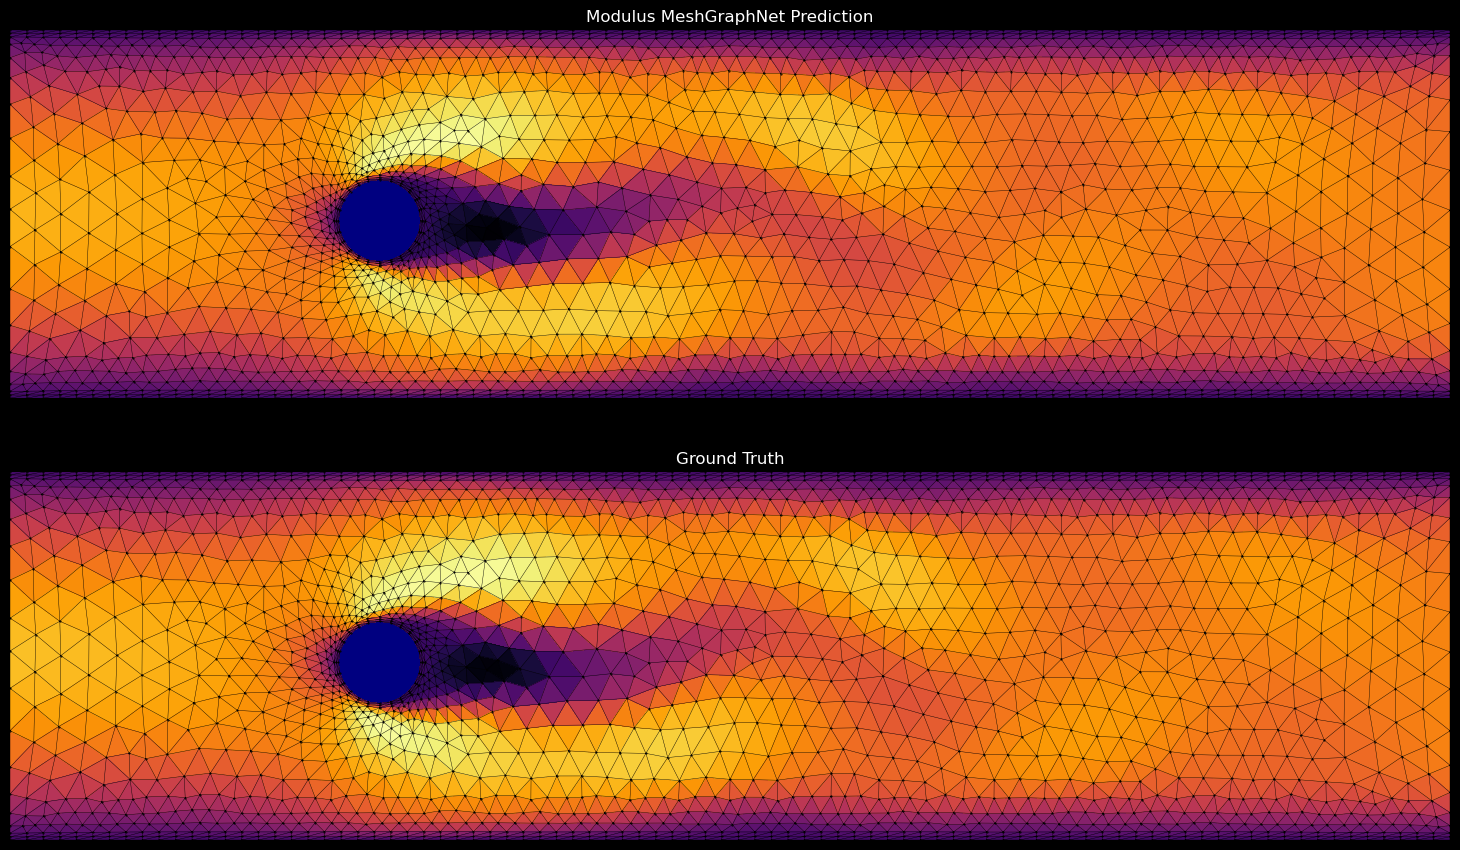

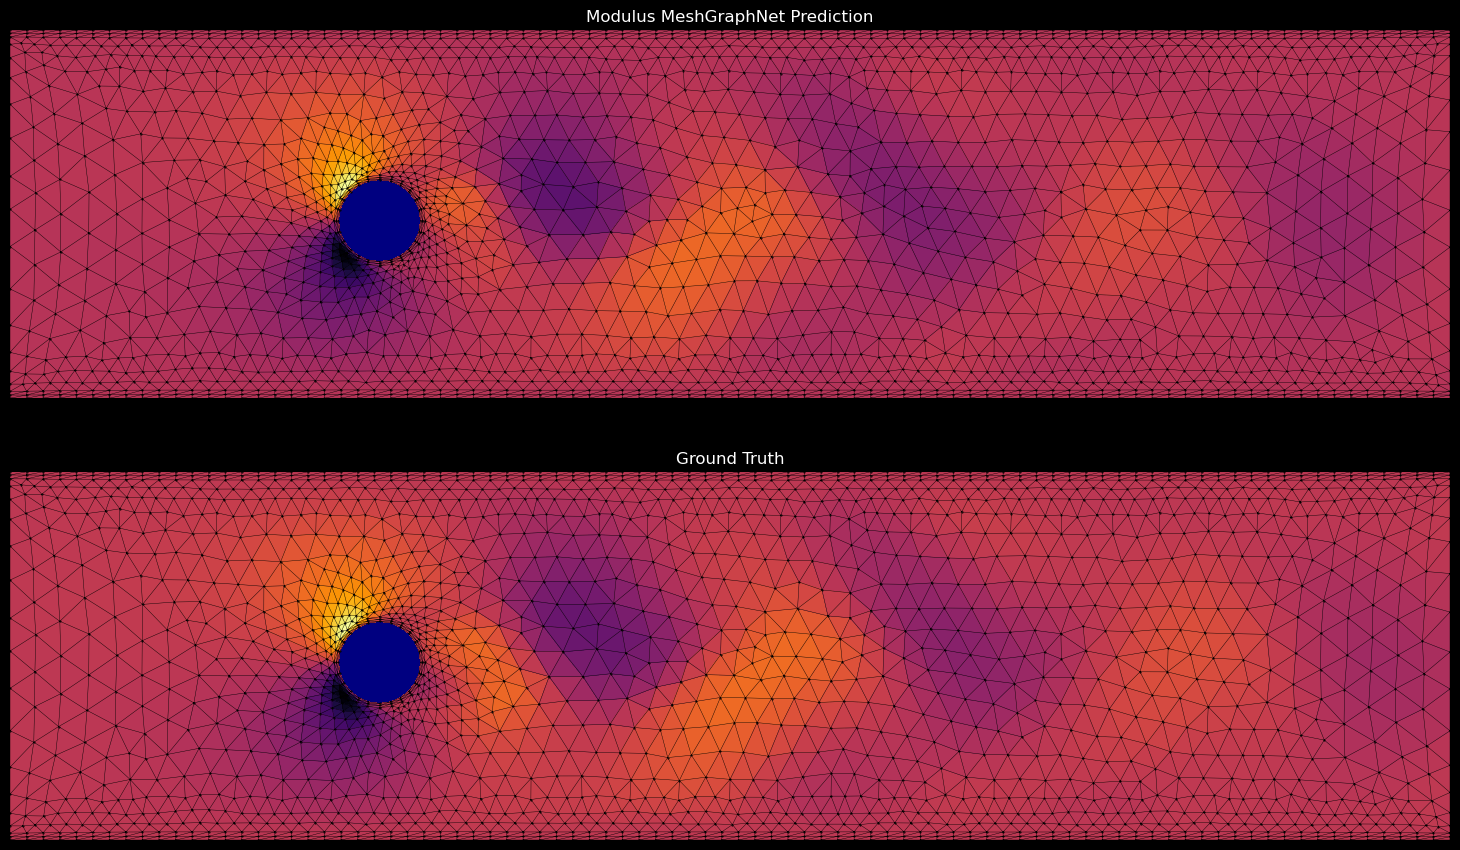

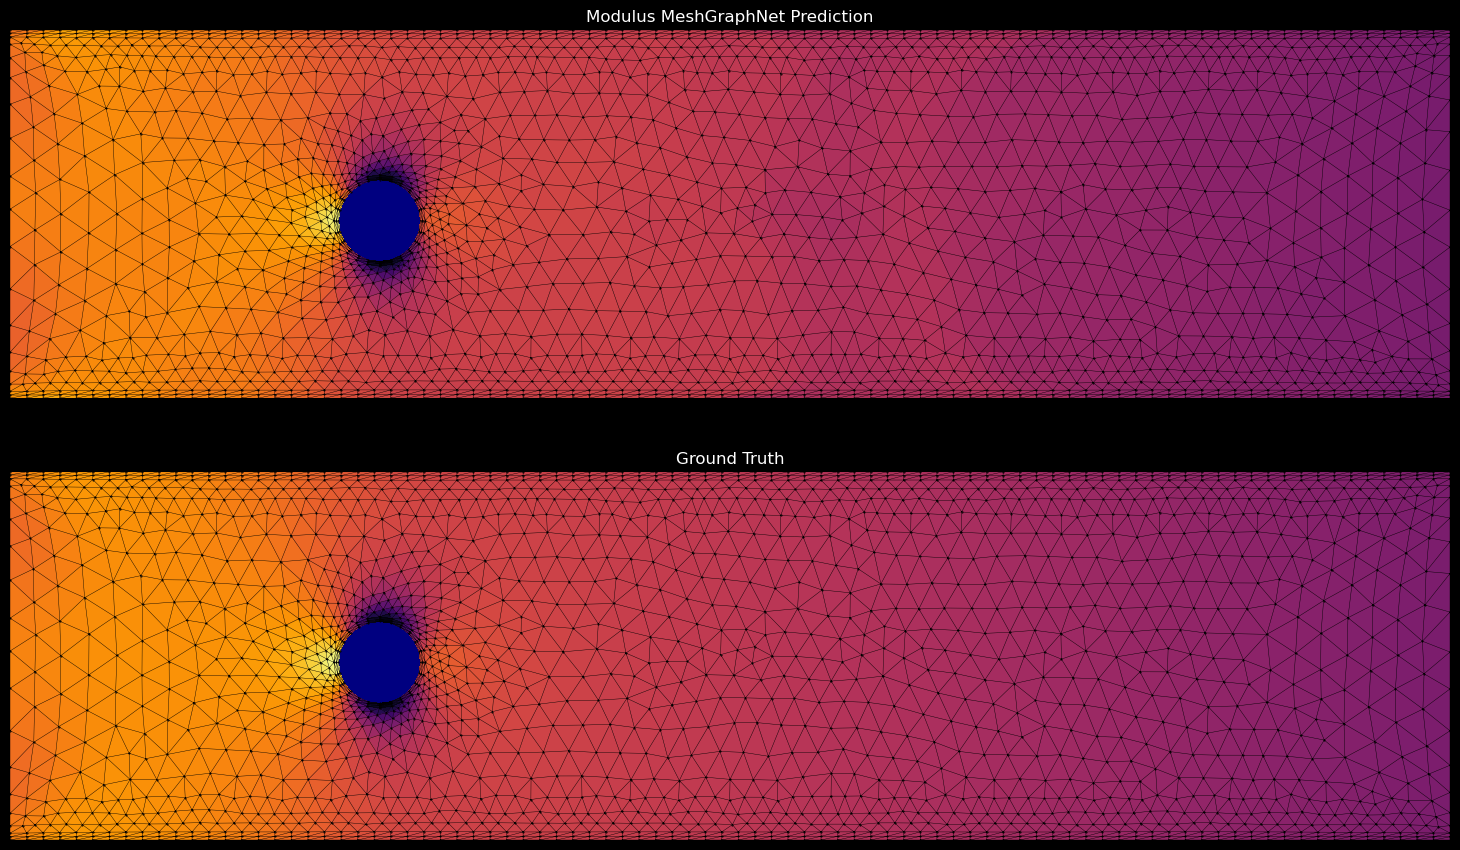

In [3]:
from matplotlib import animation

for i in idx:
    rollout.init_animation(i)
    ani = animation.FuncAnimation(
        rollout.fig,
        rollout.animate,
        frames=len(rollout.graphs) // cfg.frame_skip,
        interval=cfg.frame_interval,
    )
    ani.save("animations/animation_" + cfg.viz_vars[i] + ".gif")

## Scientific validation

Looking at the animation, we can observe that the model does a good job in predicting the transient response of the system. However, this is not sufficient to gauge the quality of the model. In the subsequent steps, we will perform a more thorough analysis on the model checkpoint and visualize the results. 

To demonstrate the concepts, and to keep the run-time at minimum, most of these metrics will be computed on a single test sample (hence the `num_test_samples` is set to `1` in the config file), but each of these metrics can easily be computed on the complete test dataset. 

In [4]:
graph, faces, pred, exact = rollout.get_raw_data(idx)

## Compute gradients to compute PDE losses

As part of the scientific analysis excercise, we would be computing several PDE and gradient based metrics. This would require the gradients of fields like `u`, `v` and `p`. The model prediction does not have gradient information, hence this will have to be done as a part of post-processing.

In [5]:
from utils import generate_mesh, compute_gradients

mesh_series = []
for i, (g, f, p, e) in enumerate(zip(graph, faces, pred, exact)):
    nodes, faces, p, e = (
        g.ndata["mesh_pos"].cpu().numpy(),
        f,
        p.cpu().numpy(),
        e.cpu().numpy(),
    )
    fields = {
        "u_true": e[:, 0],
        "v_true": e[:, 1],
        "p_true": e[:, 2],
        "u_pred": p[:, 0],
        "v_pred": p[:, 1],
        "p_pred": p[:, 2],
    }
    mesh = generate_mesh(nodes, faces, fields)
    mesh = compute_gradients(
        mesh, ["u_true", "v_true", "p_true", "u_pred", "v_pred", "p_pred"]
    )
    mesh_series.append(mesh)

## Compute L2 error

For starters, let's compute the L2 error for the model predictions. 

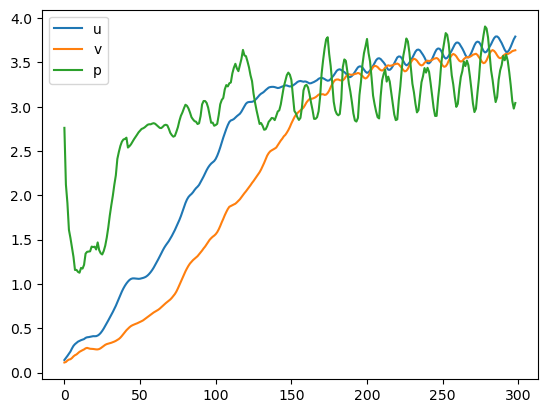

In [6]:
l2_error_u = []
l2_error_v = []
l2_error_p = []

for mesh in mesh_series:
    l2_error_u.append(
        (
            np.linalg.norm(
                mesh.point_data["u_true"].view(np.ndarray)
                - mesh.point_data["u_pred"].view(np.ndarray)
            )
        ).mean()
    )
    l2_error_v.append(
        (
            np.linalg.norm(
                mesh.point_data["v_true"].view(np.ndarray)
                - mesh.point_data["v_pred"].view(np.ndarray)
            )
        ).mean()
    )
    l2_error_p.append(
        (
            np.linalg.norm(
                mesh.point_data["p_true"].view(np.ndarray)
                - mesh.point_data["p_pred"].view(np.ndarray)
            )
        ).mean()
    )

plt.plot(l2_error_u, label="u")
plt.plot(l2_error_v, label="v")
plt.plot(l2_error_p, label="p")
plt.legend()
plt.show()

## Computing PDE residual using differential form

Now we can compute some PDE residual in the domain and plot it as a function of time. We will use the PDE utilities from PhysicsNeMo Sym to compute the Navier Stokes equation residual. 

In [7]:
from physicsnemo.sym.eq.pdes.navier_stokes import NavierStokes

ns = NavierStokes(nu=0.1, time=True, dim=2)
ns_node = ns.make_nodes()

ns.pprint()

continuity: u__x + v__y
momentum_x: u*u__x + v*u__y + p__x + u__t - 0.1*u__x__x - 0.1*u__y__y
momentum_y: u*v__x + v*v__y + p__y + v__t - 0.1*v__x__x - 0.1*v__y__y


In [8]:
continuity_true_series = []
continuity_pred_series = []

for mesh in mesh_series:
    continuity_true = ns_node[0].evaluate(
        {
            "u__x": mesh.point_data["grad_u_true"][:, 0].view(np.ndarray),
            "v__y": mesh.point_data["grad_v_true"][:, 1].view(np.ndarray),
        }
    )

    continuity_pred = ns_node[0].evaluate(
        {
            "u__x": mesh.point_data["grad_u_pred"][:, 0].view(np.ndarray),
            "v__y": mesh.point_data["grad_v_pred"][:, 1].view(np.ndarray),
        }
    )

    continuity_true_series.append(continuity_true["continuity"].sum())
    continuity_pred_series.append(continuity_pred["continuity"].sum())

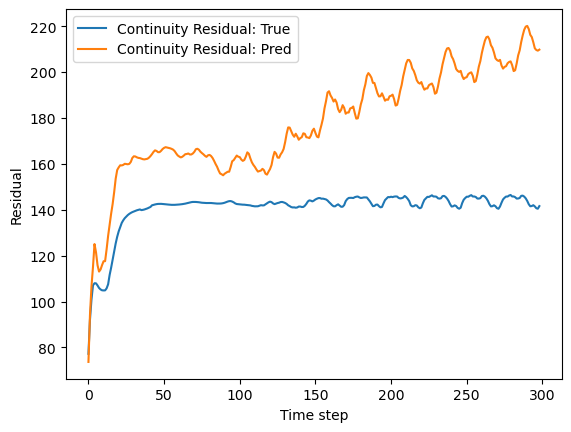

In [9]:
plt.plot(continuity_true_series, label="Continuity Residual: True")
plt.plot(continuity_pred_series, label="Continuity Residual: Pred")
plt.xlabel("Time step")
plt.ylabel("Residual")
plt.legend()

plt.show()

## Computing integral metrics

In addition to computing the PDE losses point-wise, we can compute the integral metrics like continuity loss over a control volume, drag coefficient over the cylinder surface, etc. These integrals can either be computed directly on the mesh edges or on arbitrary points/edges that are not part of the model output. We can create arbitrary control volumes/surfaces in the domain using the geometry module from PhysicsNeMo and interpolate the model predictions on those volumes/surfaces.

### Computing integrals on arbitrary surfaces


Here, we will compute the continuity loss in an integral-sense over a arbitrarily defined control volume. This involves some interpolation to compute quantities on arbitrary surfaces.

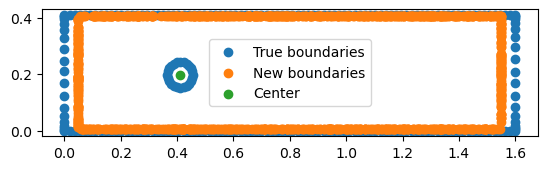

In [10]:
from physicsnemo.sym.geometry.primitives_2d import Rectangle

rec_small = Rectangle((0.05, 0.005), (1.55, 0.405))
samples = rec_small.sample_boundary(1000)

boundary_edges = mesh_series[0].extract_feature_edges(
    boundary_edges=True, feature_edges=False, manifold_edges=False
)

boundary_points = boundary_edges.points
mesh_with_normals = mesh_series[0].compute_normals(
    cell_normals=False, point_normals=True, split_vertices=True
)

point_normals = mesh_with_normals.point_data["Normals"]
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], label="True boundaries")
plt.scatter(samples["x"], samples["y"], label="New boundaries")

x_min, x_max, y_min, y_max = 0.1, 1.0, 0.1, 0.31
circle_points = boundary_points[
    (boundary_points[:, 0] >= x_min)
    & (boundary_points[:, 0] <= x_max)
    & (boundary_points[:, 1] >= y_min)
    & (boundary_points[:, 1] <= y_max)
]
plt.scatter(circle_points[:, 0].mean(), circle_points[:, 1].mean(), label="Center")
plt.legend()
plt.axis("scaled")
plt.show()

In [11]:
from utils import physicsnemo_geometry_interpolator

integral_continuity_true_series = []
integral_continuity_pred_series = []
for mesh in mesh_series:
    samples = physicsnemo_geometry_interpolator(mesh, rec_small, 1000)

    integral_continuity_true = (
        (
            samples["normal_x"] * samples["u_true"]
            + samples["normal_y"] * samples["v_true"]
        )
        * samples["area"]
    ).sum() / samples["area"].sum()
    integral_continuity_pred = (
        (
            samples["normal_x"] * samples["u_pred"]
            + samples["normal_y"] * samples["v_pred"]
        )
        * samples["area"]
    ).sum() / samples["area"].sum()

    integral_continuity_true_series.append(integral_continuity_true)
    integral_continuity_pred_series.append(integral_continuity_pred)

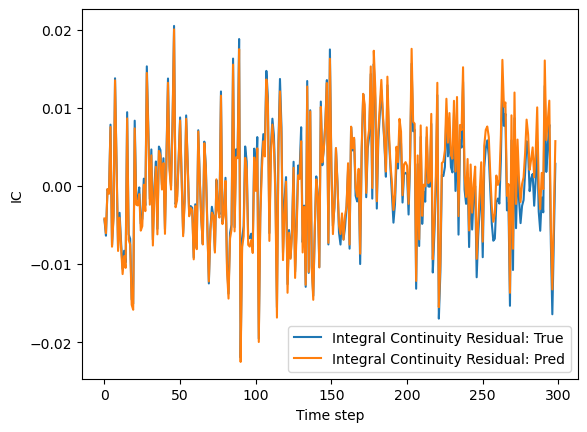

In [12]:
plt.plot(integral_continuity_true_series, label="Integral Continuity Residual: True")
plt.plot(integral_continuity_pred_series, label="Integral Continuity Residual: Pred")
plt.xlabel("Time step")
plt.ylabel("IC")
plt.legend()

plt.show()

### Computing integrals on mesh surfaces/curves

This includes computing integrals directly on the mesh edges. 

In [13]:
from utils import midpoint_data_interp
from physicsnemo.metrics.cae.integral import line_integral

force_x_pred = []
force_x_true = []
force_y_pred = []
force_y_true = []

for mesh in mesh_series:
    # Extract all the edges from the mesh
    boundary_edges = mesh.extract_feature_edges(
        boundary_edges=True, feature_edges=False, manifold_edges=False
    )

    edges = []
    for c in boundary_edges.cell:
        edges.append((c.points[0], c.points[1]))

    points = boundary_edges.points
    field_p_true = boundary_edges.point_data["p_true"]
    field_p_pred = boundary_edges.point_data["p_pred"]

    # Subsample only circle
    x_min, x_max, y_min, y_max = 0.1, 1.0, 0.1, 0.31
    criteria = {"x_min": x_min, "x_max": x_max, "y_min": y_min, "y_max": y_max}
    idx = (
            (points[:, 0] >= criteria["x_min"])
            & (points[:, 0] <= criteria["x_max"])
            & (points[:, 1] >= criteria["y_min"])
            & (points[:, 1] <= criteria["y_max"])
        )

    points = points[idx]
    field_p_true = field_p_true[idx]
    field_p_pred = field_p_pred[idx]

    point_to_index = {tuple(point): i for i, point in enumerate(points)}

    edges_subsampled = []
    for e in edges:
        pt1, pt2 = e
        pt1 = tuple(pt1)
        pt2 = tuple(pt2)
        if pt1 in point_to_index and pt2 in point_to_index:
            id1 = point_to_index[pt1]
            id2 = point_to_index[pt2]
            if id1 < len(points) and id2 < len(points):
                edges_subsampled.append([id1, id2])

    edges_subsampled = np.array(edges_subsampled)    
    
    # force vector
    p_forces_true = []
    p_forces_pred = []
    for i in range(edges_subsampled.shape[0]):
        vec = points[edges_subsampled[i, 1]] - points[edges_subsampled[i, 0]]
        normal = [vec[1], -vec[0], vec[2]]
        normal = normal / np.linalg.norm(normal)
        p_force_true = -1 * midpoint_data_interp(points[edges_subsampled[i, 0]], points[edges_subsampled[i, 1]], points, field_p_true) * normal
        p_force_pred = -1 * midpoint_data_interp(points[edges_subsampled[i, 0]], points[edges_subsampled[i, 1]], points, field_p_pred) * normal
        
        p_forces_true.append(p_force_true)
        p_forces_pred.append(p_force_pred)

    p_forces_true = np.stack(p_forces_true, axis=0)
    p_forces_pred = np.stack(p_forces_pred, axis=0)
    
    force_x_true.append(line_integral(edges_subsampled, points, p_forces_true[:,0]))
    force_x_pred.append(line_integral(edges_subsampled, points, p_forces_pred[:,0]))
    force_y_true.append(line_integral(edges_subsampled, points, p_forces_true[:,1]))
    force_y_pred.append(line_integral(edges_subsampled, points, p_forces_pred[:,1]))

force_x_pred = np.stack(force_x_pred, axis=0)
force_x_true = np.stack(force_x_true, axis=0)
force_y_pred = np.stack(force_y_pred, axis=0)
force_y_true = np.stack(force_y_true, axis=0)

force_pred = np.stack([force_x_pred, force_y_pred], axis=1)
force_true = np.stack([force_x_true, force_y_true], axis=1)

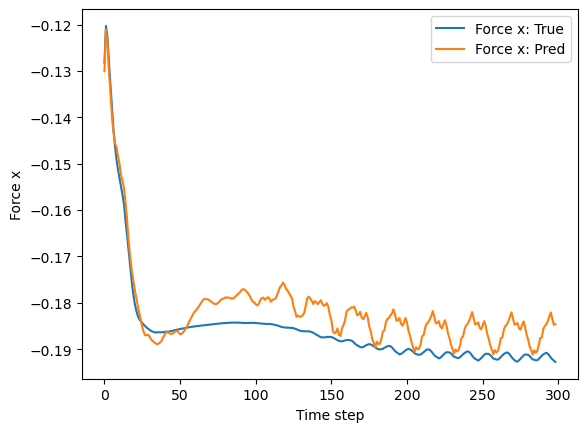

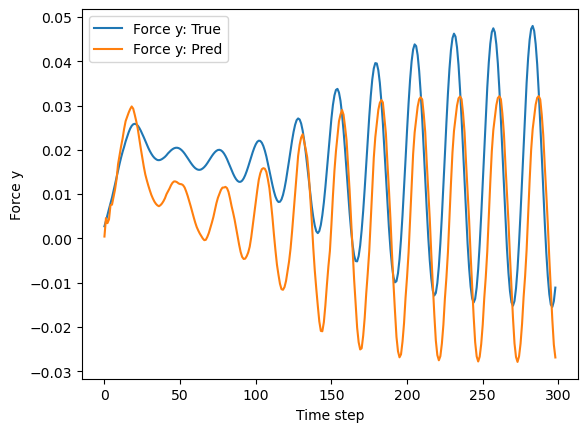

In [14]:
plt.figure()
plt.plot(force_true[:, 0].flatten(), label="Force x: True")
plt.plot(force_pred[:, 0].flatten(), label="Force x: Pred")
plt.xlabel("Time step")
plt.ylabel("Force x")
plt.legend()
plt.show()

plt.figure()
plt.plot(force_true[:, 1].flatten(), label="Force y: True")
plt.plot(force_pred[:, 1].flatten(), label="Force y: Pred")
plt.xlabel("Time step")
plt.ylabel("Force y")
plt.legend()
plt.show()

## Compute probe based quantites

Here, we will investigate the quantities at a particular point in the space. As this point may or may not be in the output mesh, we will use PhysicsNeMo geometry module to specify our probe location and then use that to compute parameters like Strouhal number, frequency of oscillation, etc. 

In [15]:
from custom_primitives import Point2D

pt = Point2D((circle_points[:, 0].mean() + 0.2, circle_points[:, 1].mean()))
sample = pt.sample_boundary(1)

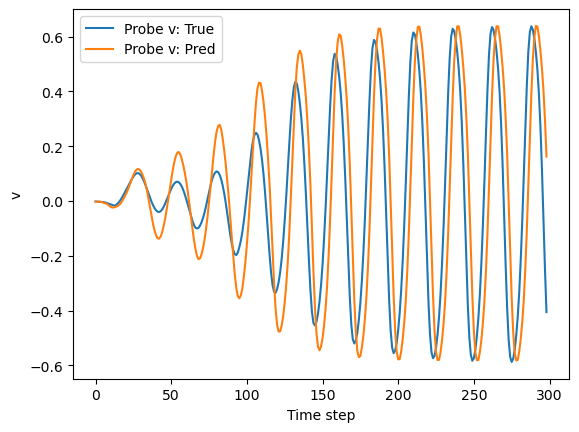

In [16]:
from utils import physicsnemo_geometry_interpolator

probe_v_true_series = []
probe_v_pred_series = []

pt = Point2D((circle_points[:, 0].mean() + 0.2, circle_points[:, 1].mean()))

for mesh in mesh_series:
    samples = physicsnemo_geometry_interpolator(mesh, pt, 1)

    probe_v_true_series.append(samples["v_true"])
    probe_v_pred_series.append(samples["v_pred"])

probe_v_true_series = np.array(probe_v_true_series)
probe_v_pred_series = np.array(probe_v_pred_series)

plt.plot(probe_v_true_series.flatten(), label="Probe v: True")
plt.plot(probe_v_pred_series.flatten(), label="Probe v: Pred")
plt.xlabel("Time step")
plt.ylabel("v")
plt.legend()

plt.show()

In [17]:
from physicsnemo.metrics.cae.cfd import dominant_freq_calc

true_signal = probe_v_true_series[150:]
pred_signal = probe_v_pred_series[150:]

print(dominant_freq_calc(true_signal), dominant_freq_calc(pred_signal))

0.0738255033557047 0.053691275167785234


That completes this scientific analysis of the checkpoint. While we can observe that the animation results look good, the scientific analysis of the model checkpoint highlights potential shortcomings of the model. Such insight is valuable when designing the models and training protocols in Physics-ML. To close, let's compute the drag force for the entire test dataset and compare the true and predicted results. We will plot the drag forces at each timestep for each sample. 

In [18]:
from utils import generate_mesh, midpoint_data_interp
from physicsnemo.metrics.cae.integral import line_integral

cfg = compose(config_name="config")
cfg["num_test_samples"] = 10

logger = PythonLogger("main")  # General python logger
logger.file_logging()

rollout = MGNRollout(cfg, logger)
idx = [rollout.var_identifier[k] for k in cfg.viz_vars]
rollout.predict()

graph, faces, pred, exact = rollout.get_raw_data(idx)

mesh_series = []
for i, (g, f, p, e) in enumerate(zip(graph, faces, pred, exact)):
    nodes, faces, p, e = (
        g.ndata["mesh_pos"].cpu().numpy(),
        f,
        p.cpu().numpy(),
        e.cpu().numpy(),
    )
    fields = {
        "u_true": e[:, 0],
        "v_true": e[:, 1],
        "p_true": e[:, 2],
        "u_pred": p[:, 0],
        "v_pred": p[:, 1],
        "p_pred": p[:, 2],
    }
    mesh = generate_mesh(nodes, faces, fields)
    mesh_series.append(mesh)

force_x_pred = []
force_x_true = []
force_y_pred = []
force_y_true = []

for mesh in mesh_series:
    # Extract all the edges from the mesh
    boundary_edges = mesh.extract_feature_edges(
        boundary_edges=True, feature_edges=False, manifold_edges=False
    )

    edges = []
    for c in boundary_edges.cell:
        edges.append((c.points[0], c.points[1]))

    points = boundary_edges.points
    field_p_true = boundary_edges.point_data["p_true"]
    field_p_pred = boundary_edges.point_data["p_pred"]

    # Subsample only circle
    x_min, x_max, y_min, y_max = 0.1, 1.0, 0.1, 0.31
    criteria = {"x_min": x_min, "x_max": x_max, "y_min": y_min, "y_max": y_max}
    idx = (
            (points[:, 0] >= criteria["x_min"])
            & (points[:, 0] <= criteria["x_max"])
            & (points[:, 1] >= criteria["y_min"])
            & (points[:, 1] <= criteria["y_max"])
        )

    points = points[idx]
    field_p_true = field_p_true[idx]
    field_p_pred = field_p_pred[idx]

    point_to_index = {tuple(point): i for i, point in enumerate(points)}

    edges_subsampled = []
    for e in edges:
        pt1, pt2 = e
        pt1 = tuple(pt1)
        pt2 = tuple(pt2)
        if pt1 in point_to_index and pt2 in point_to_index:
            id1 = point_to_index[pt1]
            id2 = point_to_index[pt2]
            if id1 < len(points) and id2 < len(points):
                edges_subsampled.append([id1, id2])

    edges_subsampled = np.array(edges_subsampled)    
    
    # force vector
    p_forces_true = []
    p_forces_pred = []
    for i in range(edges_subsampled.shape[0]):
        vec = points[edges_subsampled[i, 1]] - points[edges_subsampled[i, 0]]
        normal = [vec[1], -vec[0], vec[2]]
        normal = normal / np.linalg.norm(normal)
        p_force_true = -1 * midpoint_data_interp(points[edges_subsampled[i, 0]], points[edges_subsampled[i, 1]], points, field_p_true) * normal
        p_force_pred = -1 * midpoint_data_interp(points[edges_subsampled[i, 0]], points[edges_subsampled[i, 1]], points, field_p_pred) * normal
        
        p_forces_true.append(p_force_true)
        p_forces_pred.append(p_force_pred)

    p_forces_true = np.stack(p_forces_true, axis=0)
    p_forces_pred = np.stack(p_forces_pred, axis=0)
    
    force_x_true.append(line_integral(edges_subsampled, points, p_forces_true[:,0]))
    force_x_pred.append(line_integral(edges_subsampled, points, p_forces_pred[:,0]))
    force_y_true.append(line_integral(edges_subsampled, points, p_forces_true[:,1]))
    force_y_pred.append(line_integral(edges_subsampled, points, p_forces_pred[:,1]))

force_x_pred = np.stack(force_x_pred, axis=0)
force_x_true = np.stack(force_x_true, axis=0)
force_y_pred = np.stack(force_y_pred, axis=0)
force_y_true = np.stack(force_y_true, axis=0)

force_pred = np.stack([force_x_pred, force_y_pred], axis=1)
force_true = np.stack([force_x_true, force_y_true], axis=1)

Preparing the test dataset...


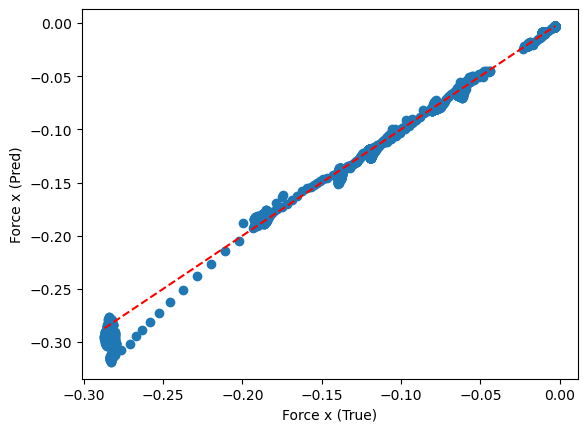

In [19]:
plt.figure()
plt.scatter(force_true[:, 0].flatten(), force_pred[:, 0].flatten())
plt.xlabel("Force x (True)")
plt.ylabel("Force x (Pred)")
x = np.linspace(
    np.min(force_true[:, 0].flatten()), np.max(force_true[:, 0].flatten()), 50
)
y = x
plt.plot(x, y, color="red", linestyle="--")
plt.show()